In [30]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.layouts import column
from rdkit import Chem
from useful_rdkit_utils import mol2numpy_fp
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from bokeh.plotting import ColumnDataSource, figure, output_file, show
import numba
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

import hdbscan
from itertools import product
import concurrent.futures
from rdkit.Chem import AllChem
from umap import UMAP
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors

import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from rdkit.Chem import PandasTools
from chemplot import Plotter

def smi2svg(smi):
    mol = Chem.MolFromSmiles(smi)
    d2d = rdMolDraw2D.MolDraw2DSVG(200, 100)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()
    

def umap(df, nbits=2048):
    """
    Compute UMAP projections for molecular data.

    Parameters:
    - df: Dataframe containing a 'ROMol' column with molecular data.

    Returns:
    - res: UMAP reduced dimensionality output.
    """
    # Compute Morgan Fingerprints
    df['fp'] = df['ROMol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=nbits))
    df['svg'] = df['Smiles'].apply(lambda x: smi2svg(x))
    # Tanimoto Distance function
    def tanimoto_dist(a, b):
        dotprod = np.dot(a, b)
        tc = dotprod / (np.sum(a) + np.sum(b) - dotprod)
        return 1.0 - tc

    # UMAP dimensionality reduction
    fps = df['fp'].apply(lambda fp: np.array(fp)).tolist()
    from umap import UMAP
    reducer = UMAP(metric=tanimoto_dist)
    res = reducer.fit_transform(fps)
    
    return res


def plot_umap(df, res):
    # Data Preparation
    colors = df['cnnaffinity'].values
    mapper = linear_cmap(field_name='sf1_values', palette=Viridis256, low=min(colors), high=max(colors))
    data = dict(
        x=res[:, 0],
        y=res[:, 1],
        #ids= for m in df['ROMol']],
        img=df['svg'],
        sf1_values=colors,
        cnn=df['cnnaffinity'],
        #cluster=df['cluster']
    )

    # Tooltip for hover functionality
    TOOLTIPS = """
    <div>
        @img{safe}
        sf1 Value: @sf1_values<br>
        cycle: @cycle <br>
        cnnaff: @cnn <br>
        
    </div>
    """

    # Bokeh visualization
    source = ColumnDataSource(data)
    p = figure(tooltips=TOOLTIPS, width=1000, height=500, title="UMAP Projection of Molecular Fingerprints")
    p.circle('x', 'y', size=10, source=source, color=mapper, alpha=0.9)

    # Create a color bar based on sf1 values
    color_mapper = LinearColorMapper(palette=Viridis256, low=min(colors), high=max(colors))
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title='sf1 Value')

    # Add the color bar to the plot
    p.add_layout(color_bar, 'right')
    output_file(filename="al.html")
    # Display the plot
    output_notebook()
    show(column(p))

'''min_cluster_size and min_samples, and experiment with cluster_selection_epsilon and cluster_selection_method.'''

def cluster_data(df, res, min_samples, min_cluster_size):
    # Apply HDBSCAN clustering on the UMAP results
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, cluster_selection_method='leaf')
    cluster_labels = clusterer.fit_predict(res)

    # Add the cluster labels to the original DataFrame
    df['cluster'] = cluster_labels
    return df

In [31]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/home/cree/code/al_data/')
oracle_csv_path = 'cs_49k.csv'
oracle_df = pd.read_csv(oracle_csv_path)


def create_test_df(directory):
    """
    Concatenate all selection.csv files from each cycle directory within the specified directory.

    Parameters:
    - directory: str, the path to the directory containing cycle folders.

    Returns:
    - all_selections_df: DataFrame, containing all the data with an additional 'cycle' column.
    """
    # Initialize an empty DataFrame
    all_selections_df = pd.DataFrame()

    # List all cycle directories in the specified directory
    cycle_dirs = [d for d in os.listdir(directory) if
                  os.path.isdir(os.path.join(directory, d)) and d.startswith('cycle_')]

    # Iterate over each directory and append the data to the DataFrame
    for cycle_dir in cycle_dirs:
        cycle_path = os.path.join(directory, cycle_dir, 'selection.csv')
        if os.path.exists(cycle_path):
            # Read the selection.csv file
            cycle_df = pd.read_csv(cycle_path)
            print(cycle_df.columns)
            new_name = 'cnnaffinity'
            if 'combo1' in cycle_df.columns:
                cycle_df.rename(columns={'combo1': new_name}, inplace=True)
            
            if 'plip' in cycle_df.columns:
                cycle_df.rename(columns={'plip': new_name}, inplace=True)
            # Add a 'cycle' column to keep track of the source
            cycle_number = int(cycle_dir.split('_')[1])  # Extract cycle number from the directory name
            cycle_df['cycle'] = cycle_number
            cycle_df['cnnaffinity'] = cycle_df['cnnaffinity'].abs()
            # cycle_df['cnnaffinity'].astype('float').dtypes

            # Append the DataFrame to the main DataFrame
            all_selections_df = pd.concat([all_selections_df, cycle_df], ignore_index=True)
    all_selections_df['expt'] = directory

    print(all_selections_df.columns)
    return all_selections_df


def calculate_performance_metrics(data_df, oracle_df, top_percentage):
    """
    Calculate performance metrics for a given dataframe.

    Parameters:
    - cycle_data: DataFrame for a specific cycle containing 'is_active' column.
    - oracle_df: DataFrame of the oracle data containing 'cnnaffinity' column.
    - threshold: Float, the threshold for determining active compounds.

    Returns:
    - A dictionary containing TP, FP, TN, FN, recall, precision, and F1 score for the cycle.
    """
    # calculate true positives (TP), false positives (FP), and false negatives (FN)
#    test = oracle_df['cnnaffinity'] >= threshold.shape[0] #TODO this has broken, fix
#    print(f'above threshold {test}')
    threshold = oracle_df['cnnaffinity'].quantile(1 - top_percentage)
    TP = data_df['is_active'].sum()  #!! just sum of all the actives, correctly identified as positive via oracle
    FN = oracle_df[oracle_df['cnnaffinity'].astype('float') >= float(threshold)].shape[0] - TP  # all the actives from the oracle, minus the ones we picked i.e. were active but we didnt pick them
    FP = data_df.shape[0] - TP  #!! num mols we picked when we shouldn't
    TN = oracle_df.shape[0] - TP - FP - FN  # only 4 options TP/TN/FP/FN; so total - (TP-FP-FN) = TN

    # ensure the counts add up to the total number of samples
    assert TP + FN + FP + TN == len(oracle_df), "Count mismatch"

    recall = TP / (TP + FN) if TP + FN > 0 else 0
    precision = TP / (TP + FP) if TP + FP > 0 else 0

    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0 #check

    print(f"True Positive (TP): {TP}")
    print(f"False Negative (FN): {FN}")
    print(f"False Positive (FP): {FP}")
    print(f"True Negative (TN): {TN}")

    # Check for Count Mismatch
    print(f"Total Samples: {len(oracle_df)}")
    print(f"Sum of Counts (TP+FN+FP+TN): {TP + FN + FP + TN}")

    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1_score}")

    return {
        'expt': [data_df['expt'].iloc[0].replace('_generated', '')], #[data_df.cycle.iloc[0]], #
        'TP': [TP],
        'FP': [FP],
        'TN': [TN],
        'FN': [FN],
        'recall': [recall],
        'precision': [precision],
        'f1_score': [f1_score]
    }


def find_active_mols(df, top_percentage, oracle_df):
    """
    Assign activity to chosen molecules from oracle

    Parameters:
    - df: DataFrame containing 'cnnaffinity'
    - top_percentage: float, the top percentage of 'cnnaffinity' values to consider as 'active'.

    Returns:
    - metrics_df: DataFrame containing 'is_active' column, where active is defined as above top_percentage score in the oracle
    """
    threshold = oracle_df['cnnaffinity'].quantile(1 - top_percentage)
    df['is_active'] = df['cnnaffinity'] >= threshold

    print(f'Threshold for {top_percentage} is {threshold}.')
    print(f'Number of active mols for {df.expt.iloc[0]} is {df.is_active.sum()}.')


    return df

from os.path import join, getsize

def gather_data(data_dir):
    dir_list = []
    for root, dirs, files in os.walk('.'):
        dir_list.append(dirs) 
    return dir_list[0]


def get_params(exp_list):
    search_strs = [text.split('_') for text in exp_list]
    flat_list = [item for sublist in search_strs for item in sublist]
    param_list = list(set(flat_list))
    return param_list

def gen_rep_data(data_dir, percent, trunc=True):
    exp_list = gather_data(data_dir)
    df_list = [create_test_df(exp) for exp in exp_list]
    percent = '0.02'
    
    if trunc:
        df_sorted = [df.sort_values(by=['cycle'])[:2500] for df in df_list]
    else:
        print(df.expt)
        df_sorted = [df.sort_values(by=['cycle']) for df in df_list]
    [len(df) for df in df_sorted]
    df_list = df_sorted
    
    dat = {percent : [find_active_mols(df, float(percent), oracle_df) for df in df_list]}
    
    
    metrics = [calculate_performance_metrics(df, oracle_df, float(percent)) for df in dat[percent]]
    
    metrics = [pd.DataFrame(dict) for dict in metrics]
    metric_df = pd.concat(metrics)
    return df_list, metric_df


def visualize_data(search_string, final_df):
    # Filter DataFrame using Search String
    search_df = final_df[final_df['expt'].str.contains(search_string)]
    
    # Melt the DataFrame for Visualization
    metrics_melted = pd.melt(search_df, id_vars='expt', value_vars=['f1_score', 'recall'], var_name='metric', value_name='score')
    
    # Plot Data
    fig, ax1 = plt.subplots()
    custom_palette = sns.color_palette("colorblind", n_colors=len(metrics_melted['metric'].unique()))
    g = sns.barplot(x='expt', y='score', hue='metric', data=metrics_melted, ax=ax1, palette=custom_palette, hatch='/')
    
    # Customize Plot
    plt.xticks(rotation=90)
    plt.title(f'{search_string} - Top {percent}')  # Note: 'percent' is not defined in the provided code snippet.
    ax1.set_ylabel('Score')
    ax1.set_xlabel('Cycle size')
    plt.legend(loc=(1.04, 0))

    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.savefig(f'{search_string}_{percent}.png', bbox_inches="tight")
    plt.show()

from rdkit import Chem

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import PandasTools

def create_violin_plot(df_combined):
    """
    Load data from a df and create a violin plot.

    Parameters:
    - directory_path: Path to the directory containing SDF files.
    - plot_title: Title for the violin plot.

    Returns:
    None.
    """
    
    
    df_combined['cycle'] = df_combined['cycle'].astype('int')
    df_combined['cnnaffinity'] = df_combined['cnnaffinity'].astype('float')
    plot_title = df_combined['expt'].iloc[0]

    # Create a violin plot of sf1 vs cycle
    sns.violinplot(x='cycle', y='cnnaffinity', data=df_combined)
    #plt.title(plot_title)
    plt.xlabel('Cycle')
    plt.ylabel('Predicted pK')
    plt.xticks(range(min(df_combined['cycle']), max(df_combined['cycle']) + 1, 2))
    plt.savefig(f'/home/cree/code/gal/cs50k/{plot_title}')
    plt.show()
    return df_combined

def plot_metric_over_cycles(df, metric, oracle_df, percent):
    # Check if the metric is valid
    if metric not in ['recall', 'precision', 'accuracy', 'f1_score']:  # Add other valid metrics if needed
        raise ValueError("Invalid metric specified.")
    expt = df['expt'].iloc[0]
    # Split df into a list of DataFrames based on the 'cycle' column
    max_cycle = df['cycle'].max()
    df_list = [df[df['cycle'] <= i] for i in range(1, max_cycle + 1)]

    # Calculate performance metrics for each DataFrame
    data = [calculate_performance_metrics(df, oracle_df, percent) for df in df_list]

    # Extracting the specified metric values from the data
    metric_values = [entry[metric][0] for entry in data]  # Adjust indexing if necessary

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(metric_values) + 1), metric_values, marker='o')
    plt.title(f'{metric.capitalize()} Values Over Different Cycles')
    plt.xlabel('Cycle')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    plt.xticks(range(1, len(metric_values) + 1))
    
    # Save the plot
    plt.savefig(f'{expt}_{metric}_{percent}.png')
    plt.show()

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.layouts import column
from rdkit import Chem
from useful_rdkit_utils import mol2numpy_fp
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from bokeh.plotting import ColumnDataSource, figure, output_file, show
import numba
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

import hdbscan
from itertools import product
import concurrent.futures
from rdkit.Chem import AllChem
from umap import UMAP
import numpy as np

def smi2svg(smi):
    mol = Chem.MolFromSmiles(smi)
    d2d = rdMolDraw2D.MolDraw2DSVG(200, 100)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()
    

def umap(df, nbits=2048):
    """
    Compute UMAP projections for molecular data.

    Parameters:
    - df: Dataframe containing a 'ROMol' column with molecular data.

    Returns:
    - res: UMAP reduced dimensionality output.
    """
    # Compute Morgan Fingerprints
    df['fp'] = df['ROMol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=nbits))
    df['svg'] = df['Smiles'].apply(lambda x: smi2svg(x))
    # Tanimoto Distance function
    def tanimoto_dist(a, b):
        dotprod = np.dot(a, b)
        tc = dotprod / (np.sum(a) + np.sum(b) - dotprod)
        return 1.0 - tc

    # UMAP dimensionality reduction
    fps = df['fp'].apply(lambda fp: np.array(fp)).tolist()
    from umap import UMAP
    reducer = UMAP(metric=tanimoto_dist)
    res = reducer.fit_transform(fps)
    
    return res


def plot_umap(df, res):
    # Data Preparation
    colors = df['cnnaffinity'].values
    mapper = linear_cmap(field_name='sf1_values', palette=Viridis256, low=min(colors), high=max(colors))
    data = dict(
        x=res[:, 0],
        y=res[:, 1],
        #ids= for m in df['ROMol']],
        img=df['svg'],
        sf1_values=colors,
        cnn=df['cnnaffinity'],
        cnn_per_mw=df['sf1'].astype('float')/df['MW'].astype('float'),
        cycle=df['cycle'],
        #cluster=df['cluster']
    )

    # Tooltip for hover functionality
    TOOLTIPS = """
    <div>
        @img{safe}
        sf1 Value: @sf1_values<br>
        cycle: @cycle <br>
        cnnaff: @cnn <br>
        
    </div>
    """

    # Bokeh visualization
    source = ColumnDataSource(data)
    p = figure(tooltips=TOOLTIPS, width=1000, height=500, title="UMAP Projection of Molecular Fingerprints")
    p.circle('x', 'y', size=10, source=source, color=mapper, alpha=0.9)

    # Create a color bar based on sf1 values
    color_mapper = LinearColorMapper(palette=Viridis256, low=min(colors), high=max(colors))
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title='sf1 Value')

    # Add the color bar to the plot
    p.add_layout(color_bar, 'right')
    output_file(filename="cyct.html")
    # Display the plot
    output_notebook()
    show(column(p))

'''e min_cluster_size and min_samples, and experiment with cluster_selection_epsilon and cluster_selection_method.'''

def cluster_data(df, res, min_samples, min_cluster_size):
    # Apply HDBSCAN clustering on the UMAP results
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, cluster_selection_method='leaf')
    cluster_labels = clusterer.fit_predict(res)

    # Add the cluster labels to the original DataFrame
    df['cluster'] = cluster_labels
    return df

import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors

In [22]:
# data_dir = '/home/cree/code/gal/cs50k/rep_3'
# os.chdir(data_dir)

# exp_list = gather_data(data_dir)
# exp_list

# param_list = get_params(exp_list)
# param_list

# percent = 0.02

# df_list, rep3_df = gen_rep_data(data_dir, percent, trunc=False)

Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid', 'cycle', 'expt'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index([

KeyError: 'cycle'

In [32]:
base_dir = '/home/cree/code/gal/cs50k/'

# create 5 dfs in a loop with different directories for each
dfs = {}
for i in [1,2,4,5]:
    data_dir = f'{base_dir}rep_{i}'  # change directory for each rep
    os.chdir(data_dir)
    
    df_name = f'rep{i}_df'  # naming each df as rep1_df, rep2_df, etc.
    dfs[df_name], _ = gen_rep_data(data_dir, percent, trunc=False)

# Access dataframes: dfs['rep1_df'], dfs['rep2_df'], ..., dfs['rep5_df']
dfs

Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid', 'cycle', 'expt'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'fid'], dtype='object')
Index([

{'rep1_df': [      cnnaffinity                                             Smiles  h  \
  1800      4.62074  [H]c1nc([H])c(C(=O)OC(=NN([H])C(=S)N([H])[H])C...  6   
  1927      4.55517  [H]c1nc([H])c(C(=O)N([H])C([H])([H])OS(=O)(=O)...  6   
  1928      4.44104  [H]c1nc([H])c(C(=O)N(N([H])C(=O)c2c([H])c([H])...  6   
  1929      5.20608  [H]c1nc([H])c(-c2nc(N([H])C(=O)N([H])c3c([H])c...  6   
  1930      0.00000  [H]c1nc([H])c(C#Cc2nc([H])c(-c3c([H])nc([H])c(...  6   
  ...           ...                                                ... ..   
  129       4.95743  [H]c1nc([H])c([C@@]([H])(N([H])c2nc(C(F)(F)F)c...  6   
  128       4.94510  [H]c1nc([H])c(C([H])([H])Sc2nc(C(F)(F)F)c([H])...  6   
  127       4.77295  [H]c1nc([H])c(-c2c([H])c([H])nc(C(=O)N(C([H])(...  6   
  137       5.05595  [H]c1nc([H])c(-n2nnc(-c3c([H])c([H])c(C([H])([...  6   
  0         5.11229  [H]c1nc(N2C([H])([H])C([H])([H])N(n3c([H])nc(-...  6   
  
          fid  cycle                      expt  is_active  
  

In [47]:
dfs['rep1_df']

Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 

In [ ]:
df_list[0]['ROMol'] = df_list[0]['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))
df_list[0]['MW'] = df_list[0]['ROMol'].apply(lambda x: Descriptors.ExactMolWt(x))
df_list[0]['sf1'] = df_list[0]['cnnaffinity']

True Positive (TP): 1
False Negative (FN): 991
False Positive (FP): 199
True Negative (TN): 48386
Total Samples: 49577
Sum of Counts (TP+FN+FP+TN): 49577
Recall: 0.0010080645161290322
Precision: 0.005
F1 Score: 0.0016778523489932886
True Positive (TP): 8
False Negative (FN): 984
False Positive (FP): 392
True Negative (TN): 48193
Total Samples: 49577
Sum of Counts (TP+FN+FP+TN): 49577
Recall: 0.008064516129032258
Precision: 0.02
F1 Score: 0.011494252873563218
True Positive (TP): 24
False Negative (FN): 968
False Positive (FP): 576
True Negative (TN): 48009
Total Samples: 49577
Sum of Counts (TP+FN+FP+TN): 49577
Recall: 0.024193548387096774
Precision: 0.04
F1 Score: 0.03015075376884422
True Positive (TP): 42
False Negative (FN): 950
False Positive (FP): 758
True Negative (TN): 47827
Total Samples: 49577
Sum of Counts (TP+FN+FP+TN): 49577
Recall: 0.04233870967741935
Precision: 0.0525
F1 Score: 0.046875
True Positive (TP): 59
False Negative (FN): 933
False Positive (FP): 941
True Negative 

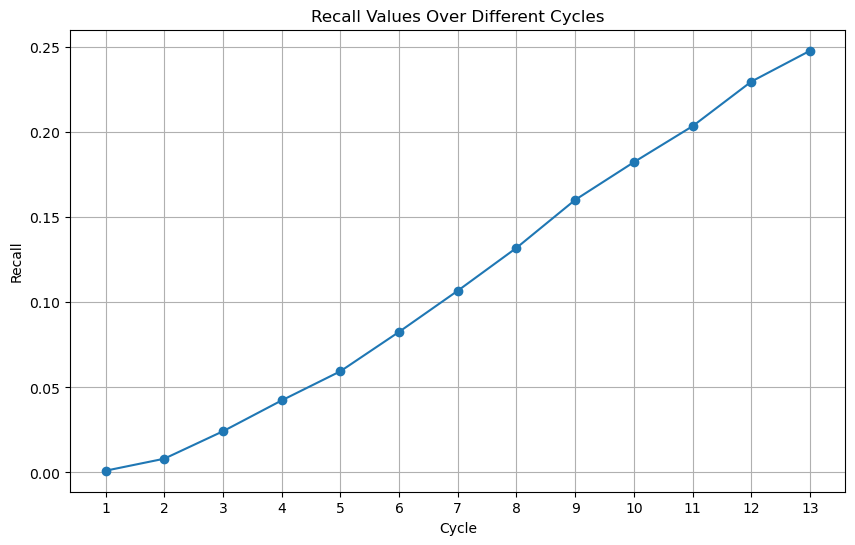

In [11]:
import pandas as pd
df = df_list[0]
# Assuming 'df' is your original DataFrame
max_cycle = df['cycle'].max()
df_list = [df[df['cycle'] <= i] for i in range(1, max_cycle + 1)]
df_list
data = [calculate_performance_metrics(df, oracle_df, percent) for df in df_list]
import matplotlib.pyplot as plt

# Extracting recall values from the data
recalls = [entry['recall'][0] for entry in data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(recalls) + 1), recalls, marker='o')
plt.title('Recall Values Over Different Cycles')
plt.xlabel('Cycle')
plt.ylabel('Recall')
plt.grid(True)
plt.xticks(range(1, len(recalls) + 1))
plt.show()

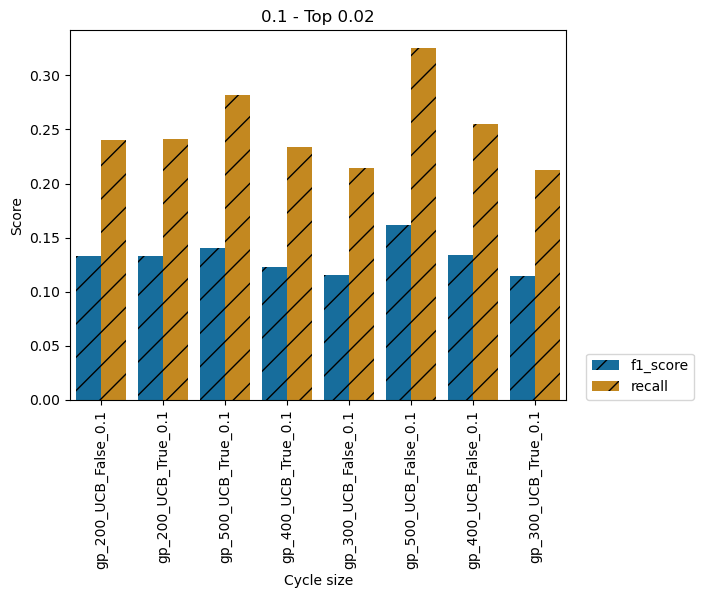

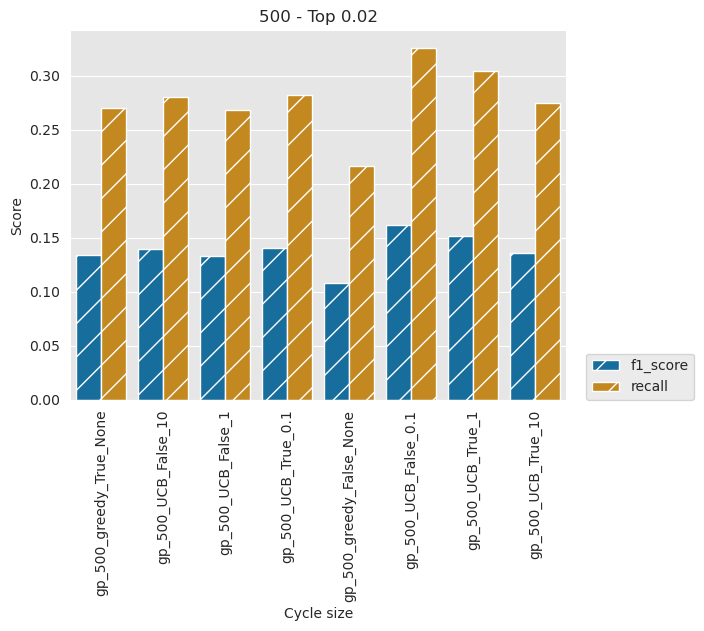

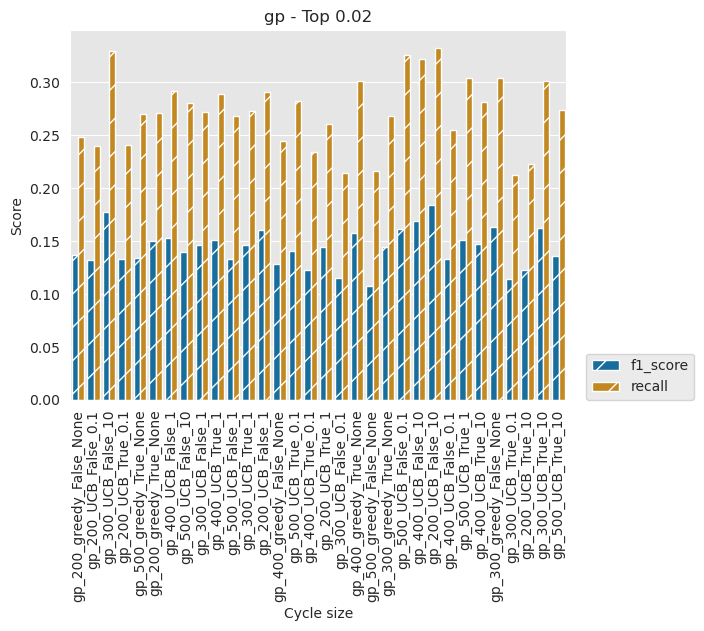

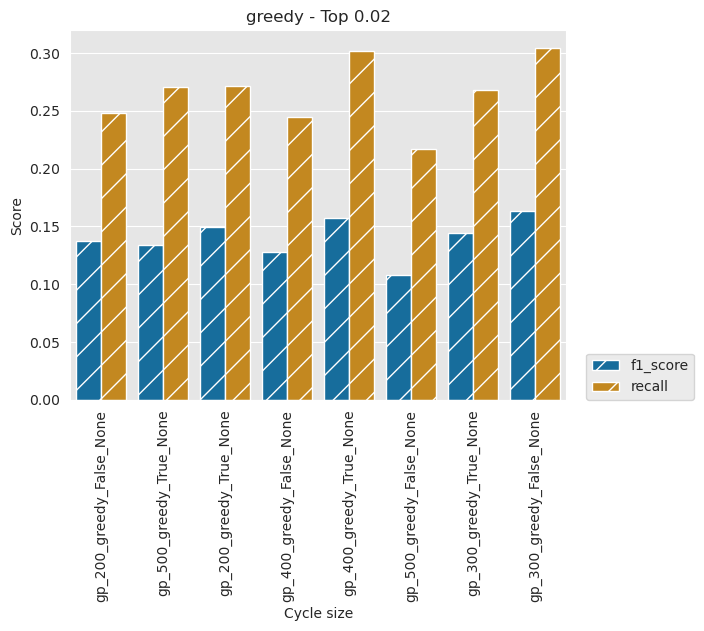

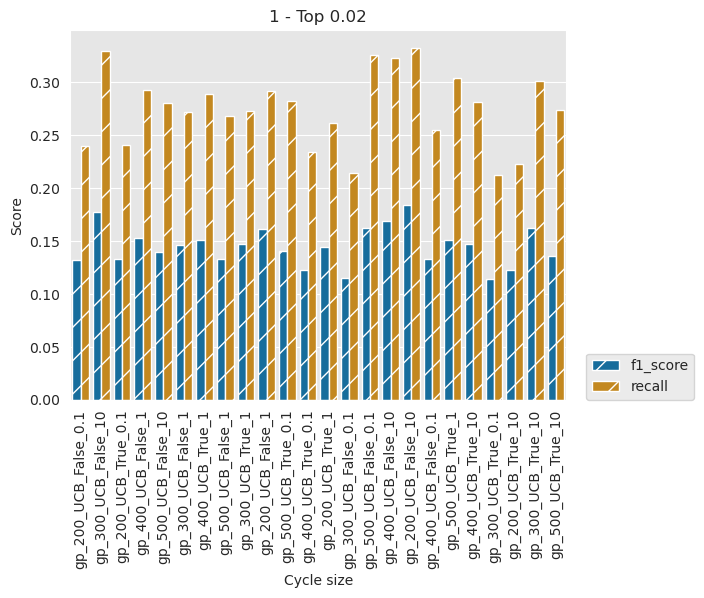

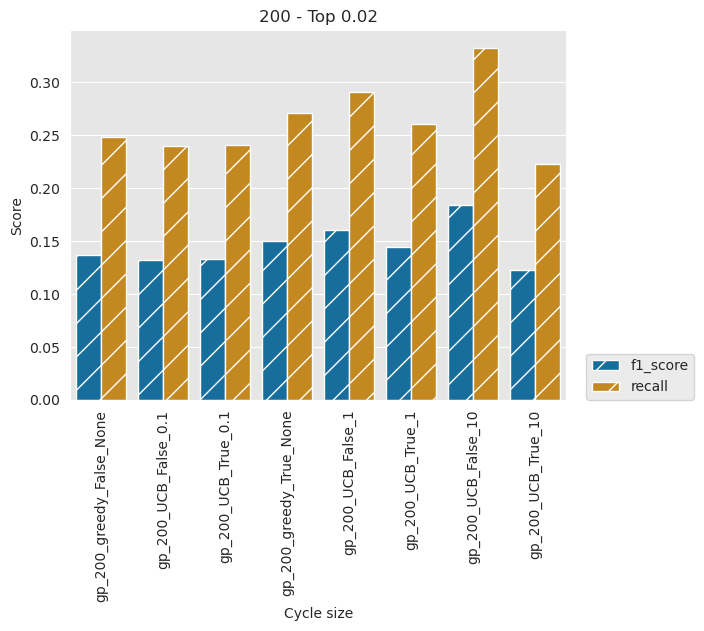

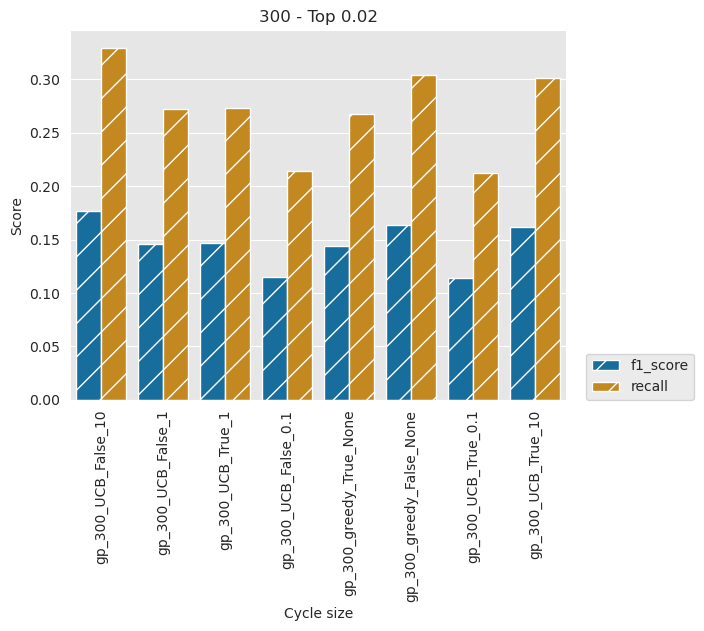

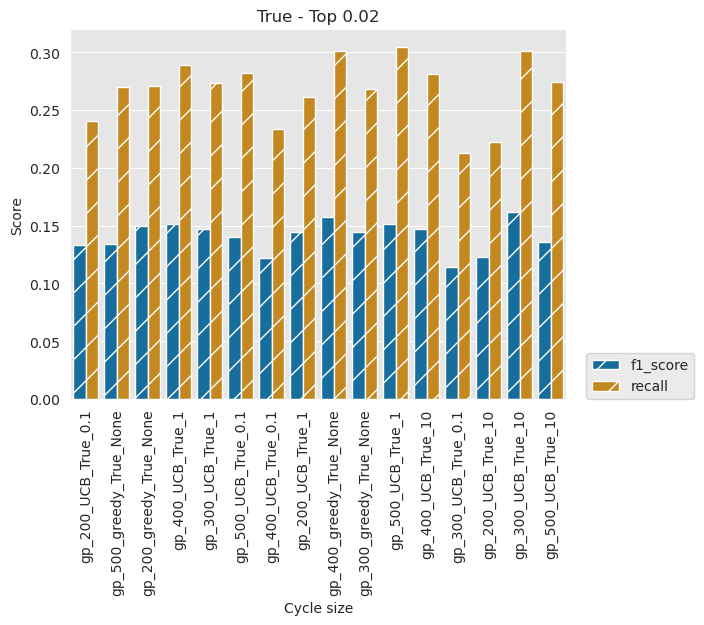

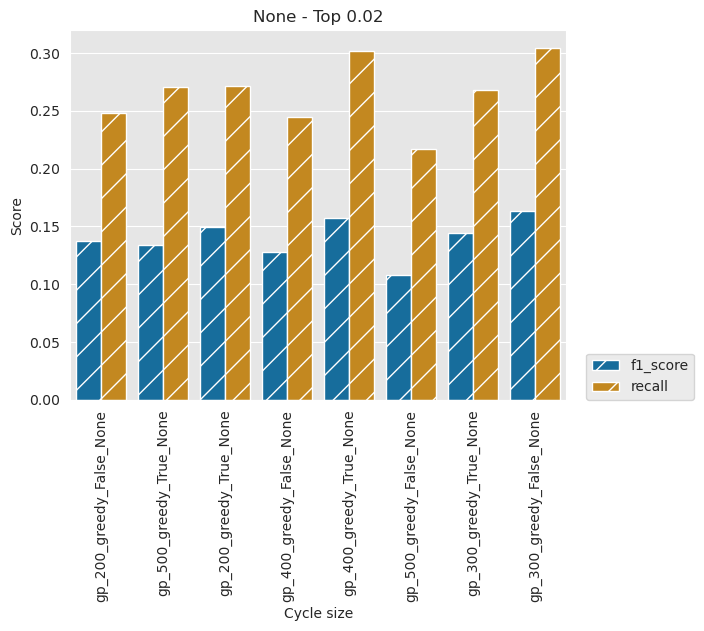

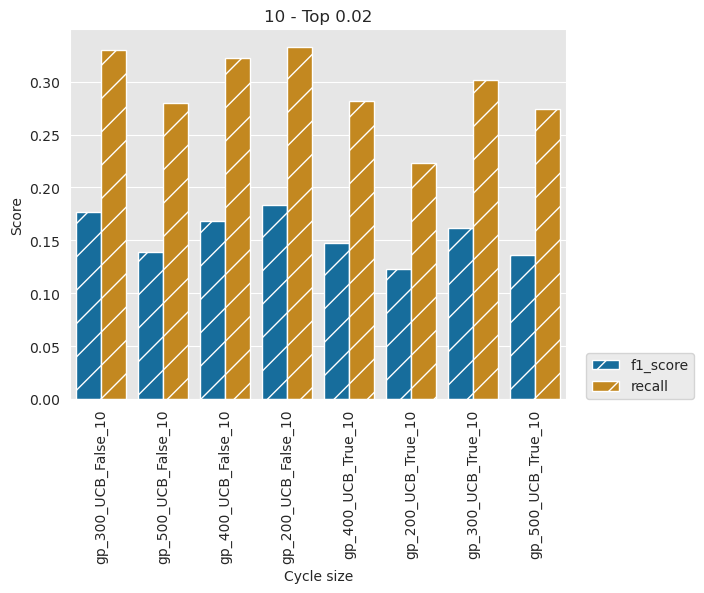

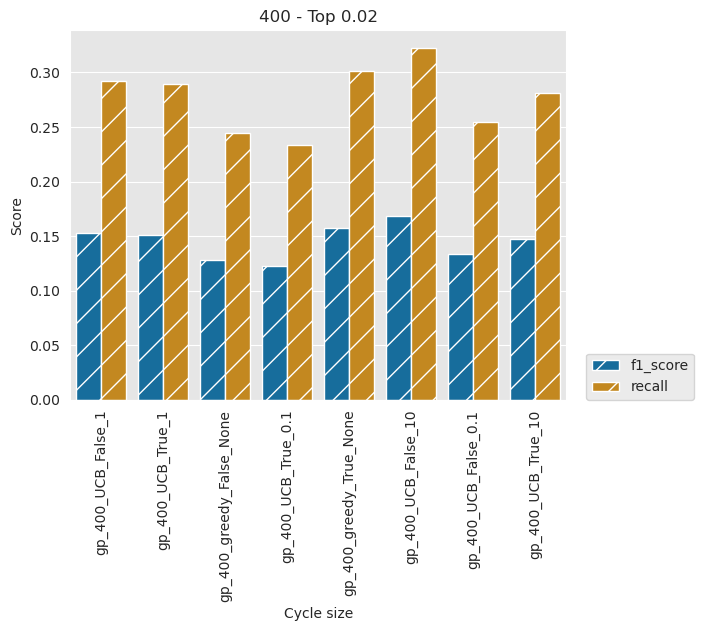

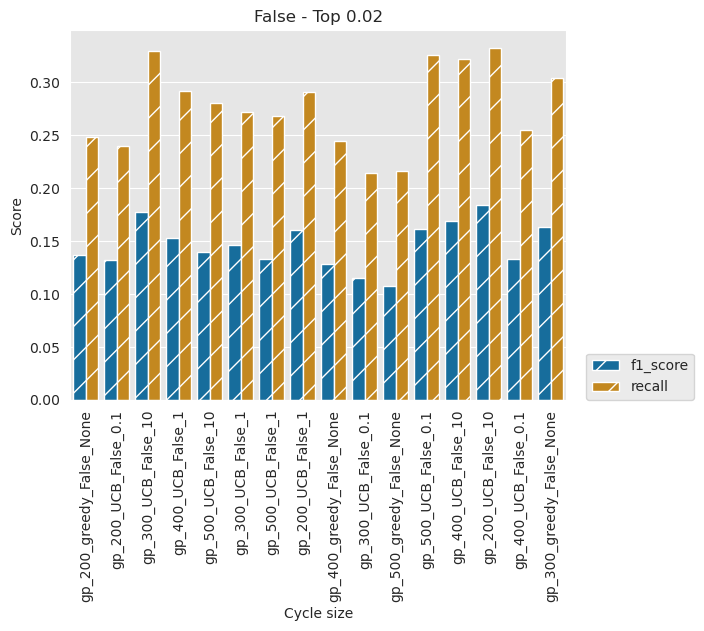

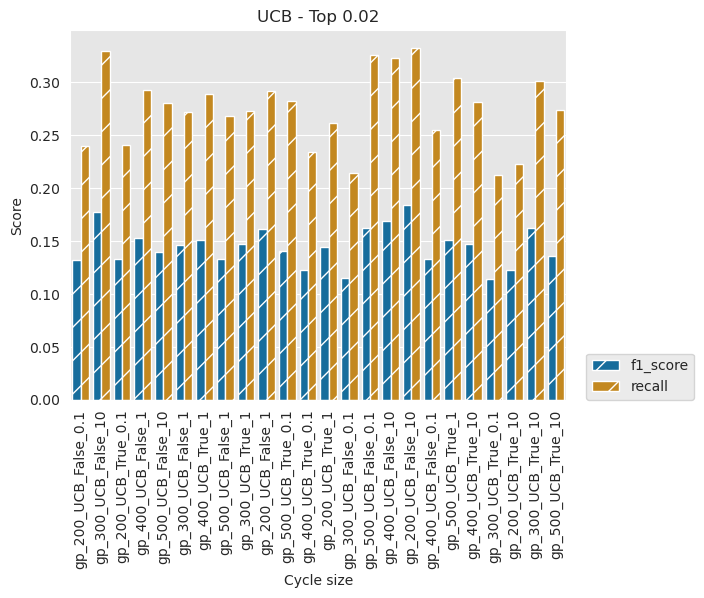

In [12]:
for i in param_list:
    visualize_data(i, rep1_df)

In [36]:
def visualize_avg_data(search_terms, df_list):
    # Combine all DataFrames in the list
    combined_df = pd.concat(df_list)
    
    # Convert search_terms to a list if it's a single string
    if isinstance(search_terms, str):
        search_terms = [search_terms]
    
    # Apply AND logic in filtering: all terms must be present
    mask = combined_df['expt'].apply(lambda x: all(term in x for term in search_terms))
    search_df = combined_df[mask]
        # Calculate Mean and Standard Deviation
    mean_df = search_df.groupby('expt')[['f1_score', 'recall']].mean().reset_index()
    std_df = search_df.groupby('expt')[['f1_score', 'recall']].sem().reset_index()
    
    # Melt the DataFrames for Visualization
    mean_melted = pd.melt(mean_df, id_vars='expt', value_vars=['f1_score', 'recall'], var_name='metric', value_name='mean_score')
    std_melted = pd.melt(std_df, id_vars='expt', value_vars=['f1_score', 'recall'], var_name='metric', value_name='std_dev')
    
    # Merge Mean and Standard Deviation Data
    merged_df = pd.merge(mean_melted, std_melted, on=['expt', 'metric'])
    print(merged_df)
    # Plot Data
    fig, ax1 = plt.subplots()
    custom_palette = sns.color_palette("colorblind", n_colors=len(merged_df['metric'].unique()))
    g = sns.barplot(x='expt', y='mean_score', hue='metric', data=merged_df, ax=ax1, palette=custom_palette, hatch='/', )
    
    # Add Error Bars
    for i, bar in enumerate(g.patches):
        bar.set_width(0.3)
        hue_index = i % len(merged_df['metric'].unique())
        x = bar.get_x() #+ bar.get_width() #* hue_index
        y = bar.get_height()
        error = merged_df.iloc[i]['std_dev']
        ax1.errorbar(x + bar.get_width()/2, y, yerr=error, fmt='none', color='black', capsize=3)
    
    # Customize Plot
    plt.xticks(rotation=90)
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=10)
    plt.title(f'{search_terms[0]} Metrics')
    ax1.set_ylabel('Score')
    ax1.set_xlabel('Experiment')
    plt.legend(loc=(1.04, 0))
    plt.xticks(rotation=90)
    custom_xtick_labels = ['false', 'tru',]# 'Label3', ...]  # Replace with actual labels
    ax1.set_xticklabels(custom_xtick_labels, fontsize=10, rotation=90)
    plt.title(f'{search_terms[0]} Metrics')
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.show()

In [46]:
rep1_df = dfs['rep1_df'][0]
rep2_df = dfs['rep2_df'][0]
rep4_df = dfs['rep4_df'][0]
rep5_df = dfs['rep5_df'][0]
df

,cnnaffinity,Smiles,h,fid,cycle,expt,is_active
1800,4.62074,[H]c1nc([H])c(C(=O)OC(=NN([H])C(=S)N([H])[H])C...,6,42629,1,gp_200_greedy_False_None,False
1927,4.55517,[H]c1nc([H])c(C(=O)N([H])C([H])([H])OS(=O)(=O)...,6,30113,1,gp_200_greedy_False_None,False
1928,4.44104,[H]c1nc([H])c(C(=O)N(N([H])C(=O)c2c([H])c([H])...,6,45347,1,gp_200_greedy_False_None,False
1929,5.20608,[H]c1nc([H])c(-c2nc(N([H])C(=O)N([H])c3c([H])c...,6,46552,1,gp_200_greedy_False_None,False
1930,0.00000,[H]c1nc([H])c(C#Cc2nc([H])c(-c3c([H])nc([H])c(...,6,36558,1,gp_200_greedy_False_None,False
...,...,...,...,...,...,...,...
129,4.95743,[H]c1nc([H])c([C@@]([H])(N([H])c2nc(C(F)(F)F)c...,6,49527,13,gp_200_greedy_False_None,False
128,4.94510,[H]c1nc([H])c(C([H])([H])Sc2nc(C(F)(F)F)c([H])...,6,49523,13,gp_200_greedy_False_None,False
127,4.77295,[H]c1nc([H])c(-c2c([H])c([H])nc(C(=O)N(C([H])(...,6,17776,13,gp_200_greedy_False_None,False
137,5.05595,[H]c1nc([H])c(-n2nnc(-c3c([H])c([H])c(C([H])([...,6,46864,13,gp_200_greedy_False_None,False


In [45]:
visualize_avg_data(["0.1", "200"], [rep1_df])

KeyError: "Columns not found: 'f1_score', 'recall'"

In [ ]:
#f1/recall plots works above

Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 'h', 'enamine_id', 'enamine_searched'], dtype='object')
Index(['cnnaffinity', 'Smiles', 

NameError: name 'ax' is not defined

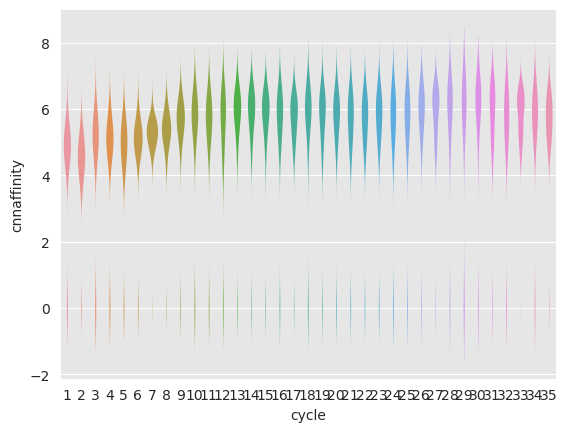

In [53]:
#TODO rainbow violin plot(s)
import seaborn as sns
import matplotlib.pyplot as plt

def create_violin_plot(df_combined, title, hline=None):
    """
    Load data from a df and create a violin plot with optional horizontal line.
    
    Parameters:
    - df_combined: DataFrame containing the data.
    - hline: Optional; y-value for a horizontal line across the plot.
    
    Returns:
    None.
    """
    
    df_combined['cycle'] = df_combined['cycle'].astype('int')
    df_combined['cnnaffinity'] = df_combined['cnnaffinity'].astype('float')
    plot_title = df_combined['expt'].iloc[0]

    # create violin plot without black borders and with specified inner
    sns.violinplot(x='cycle', y='cnnaffinity', data=df_combined, linewidth=0, edgecolor='none')
    ax.set_facecolor('white')
    # add optional horizontal line
    if hline is not None:
        plt.axhline(y=hline, color='black', linewidth=2)  # increase thickness of hline
    
    plt.xlabel('Cycle')
    plt.ylabel('Predicted pK')
    
    plt.xticks(range(min(df_combined['cycle']), max(df_combined['cycle']) + 1, 2))
    plt.savefig(f'/home/cree/code/gal/cs50k/{title}')
    plt.show()
    return df_combined
dirs = ['sars-cov-2-main-protease-al-study','sars-cov-2-main-protease-al-study-b10-r1-extended', 'sars-cov-2-main-protease-al-study-combo1', \
 'sars-cov-2-main-protease-al-study-plip']

for d in dirs:
    combined_df = create_test_df(f'/home/cree/code/gal/cs50k/enamine_study/{d}/generated')
    
    combined_df = combined_df.rename(columns={'Cycle': 'cycle'})
    create_violin_plot(combined_df, hline=None, title=f'/home/cree/code/al_data/{d}.png')

In [ ]:
#TODO umap + umap by cycle 1/13

In [ ]:
from rdkit.Chem.Descriptors import ExactMolWt
oracle_df['MW'] = oracle_df['ROMol'].apply(lambda x: ExactMolWt(x))


# plotting the histogram with adjustments
plt.hist(oracle_df['MW'], color='lightgrey', edgecolor='black', bins=50)

# removing gridlines
plt.grid(False)

# setting x-axis label to 'MW'
plt.xlabel('MW')
plt.savefig('oracle_mw')
# removing title and showing the plot
plt.show()

In [ ]:
oracle_csv_path = 'cs_49k.csv'
oracle_df = pd.read_csv(oracle_csv_path)
# Identify duplicates based on 'Smiles' and 'cnnaffinity'
duplicates = oracle_df[oracle_df.duplicated(subset=['Smiles', 'cnnaffinity'], keep=False)]
duplicates

In [7]:
sdf = 'onebyone_it14_over6cnnaffinity.sdf'
enamine_df = PandasTools.LoadSDF(sdf)
enamine_df

FileNotFoundError: [Errno 2] No such file or directory: 'onebyone_it14_over6cnnaffinity.sdf'

In [ ]:
enamine_df = enamine_df.rename(columns={'filename': 'Smiles',})
enamine_df 

In [8]:
oracle_df = oracle_df.reset_index(drop=True,)
enamine_df = enamine_df.reset_index(drop=True,)
enamine_oracle_df = pd.concat([oracle_df, enamine_df])
enamine_oracle_df = enamine_oracle_df[['Smiles','cnnaffinity', 'enamine_id']]
enamine_oracle_df.fillna(0,inplace=True)
enamine_oracle_df.cnnaffinity = enamine_oracle_df.cnnaffinity.astype('float').abs()
enamine_oracle_df

NameError: name 'enamine_df' is not defined

In [9]:
cp = Plotter.from_smiles(enamine_oracle_df["Smiles"],)
res = cp.umap()

NameError: name 'enamine_oracle_df' is not defined

array([[<AxesSubplot:title={'center':'cnnaffinity'}>]], dtype=object)

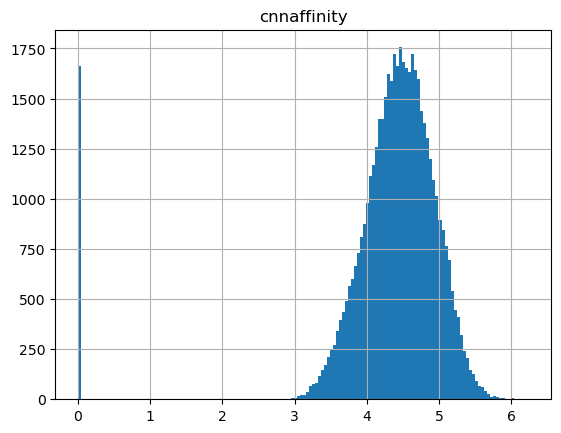

In [10]:
oracle_df.hist('cnnaffinity', bins=150)